# Import

In [1]:
import os
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from scipy import stats
from statsmodels.tsa.stattools import acf

from src.new_env import stationary_bootstrap, PortfolioEnv

In [4]:
spy_file_loc = './dataset/spx.csv'
spy_df = pd.read_csv(spy_file_loc)
spy_df.head(5)

,Date,spx,spx_normalised,log_price,log_return,dt,spx_max_drawdown,spx_max_drawdown_dur
0,4/1/1995,460.709991,1.003485,6.132769,0.003479,0.002740,-0.000803,1 days
1,5/1/1995,460.339996,1.002679,6.131965,-0.000803,0.002740,NaN,0 days
2,6/1/1995,460.679993,1.003420,6.132704,0.000738,0.002740,NaN,0 days
3,9/1/1995,460.829987,1.003746,6.133029,0.000326,0.008219,NaN,0 days
4,10/1/1995,461.679993,1.005598,6.134872,0.001843,0.002740,-0.000087,2 days


# EDA

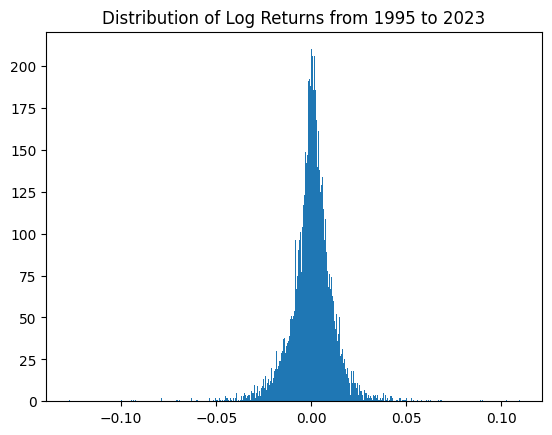

In [5]:
plt.hist(spy_df['log_return'], bins=500)
plt.title('Distribution of Log Returns from 1995 to 2023')
plt.show()

As the underlying data is a time-series, a static histogram across 2 decades will be misleading. We shall analyze the distribution of the underlying through rolling statistics.

In [6]:
DAYS_IN_YEAR = 252
desc_df = spy_df[['Date','log_return']].copy()
rolling_window = desc_df['log_return'].rolling(DAYS_IN_YEAR)
desc_df['rolling_mean'] = rolling_window.mean()
desc_df['rolling_std'] = rolling_window.std(ddof=1)
desc_df.tail(5)

,Date,log_return,rolling_mean,rolling_std
7294,2023-12-21,0.010249,0.000860,0.008425
7295,2023-12-22,0.001659,0.000808,0.008379
7296,2023-12-26,0.004223,0.000883,0.008325
7297,2023-12-27,0.001429,0.000865,0.008319
7298,2023-12-28,0.000370,0.000883,0.008314


From here, we can see that the distribution is very unlikely to be stationary. Moreover, we do see some autocorrelation structure behind the volatility.

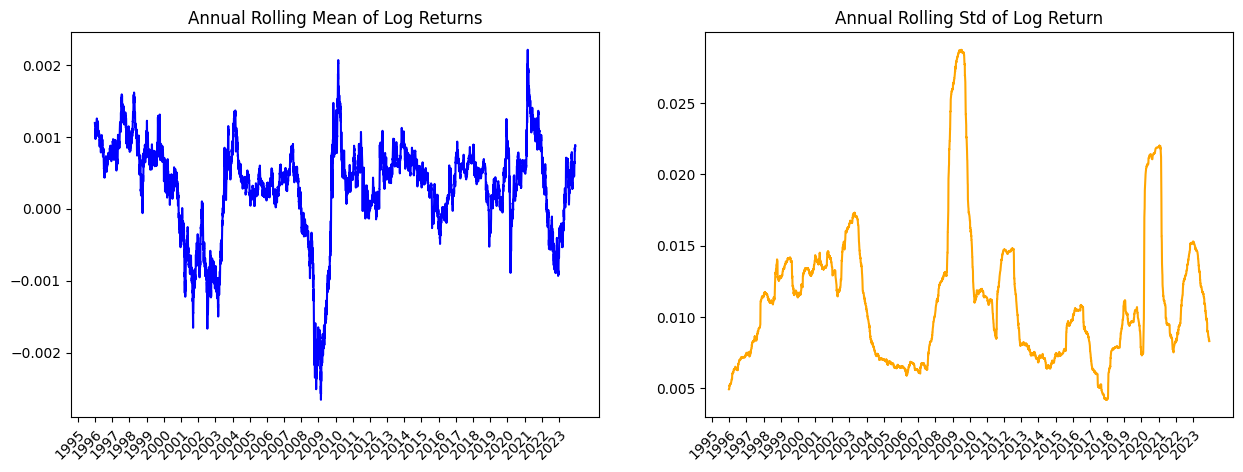

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(desc_df['Date'],desc_df['rolling_mean'], color='blue')
axes[0].set_title('Annual Rolling Mean of Log Returns')
axes[1].plot(desc_df['rolling_std'], color='orange')
axes[1].set_title('Annual Rolling Std of Log Return')

tick_positions = range(3, len(desc_df)-3, 252)
for i in range(2):
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(desc_df['Date'].iloc[tick_positions].str[:4], rotation=45, 
                            ha="right", rotation_mode="anchor")

plt.show()

# Stationary Block Boostrapping

In order to simulate the SPY returns, there are two important properties that must hold: (i) Convergence in Distribution and (ii) Volatility Clustering.

Though the paper uses a LSTM neural network to simulate the data, we will simplify the process by using a stationary block bootstrapping. Our reasoning is as follows:
- **Local Stationarity Holds Over Short Horizons**: The bootstrap resamples short, contiguous blocks in which the distribution of returns is approximately stable. By stitching these blocks together, it preserves short-range dependence.
- **Convergence in Distribution**: As $n \to \infty$ and $t \to \infty$ at a slower rate than $n$, the bootstrap distribution converges to the same asymptotic distribution as the original data.
- **Volatility Clustering**: Financial returns exhibit autocorrelation and breaking structure also destroys this property. However, block bootstrap preserves short-range dependence within blocks and will be at least partially preserved.

Nonetheless, there will be limitations:
- **Finite-sample issue**: With short samples or poorly chosen block length, volatility dynamics may be distorted.
- **Long-memory volatility**: Requires very large blocks, which reduces resample diversity.
- **No new volatility shocks or unseen data**: Bootstrap cannot create what was not observed.

In [8]:
seed=123
underlying = spy_df['log_return'].dropna()

## Convergence in Distribution
To assess whether our stationary block bootstrap successfully reproduces the marginal distribution of the underlying data, we apply the two-sample Kolmogorov–Smirnov (KS) test across bootstrap replications of varying lengths. The two-sample KS test is a nonparametric goodness-of-fit test that compares the empirical cumulative distribution functions (ECDFs) of two samples by taking the maximum difference in vertical distance.
$$
D_{n,m} = \sup_x{|F_n(x) - G_m(x)|}
$$

The hypotheses tested are:
$$H_0: F(x) = G(x)$$
$$H_A: F(x) \neq G(x)$$

We ran 1000 simulations at increasing time horizons, using timesteps ranging from 256 to the total length of our dataset, in increment of 256 days. Then, we ran the two-sample KS test between the bootstrap-simulated sample and the underlying data, recording the number of simulations where $H_0$ is rejected at the $\alpha = 0.05$ level.

However, we must be wary of the limitation of this method. The two-sample KS test assumes the following: (i) two sample distributions are independent, and (ii) samples are i.i.d. from continuous distributions. Our method clearly violates these assumptions. Since we drew the bootstap samples from the original sample, the bootstrap is dependent on the underlying. Moreover in the stationary block bootstrap, the sampling is also serially dependent due to overlapping blocks. Hence, the p-values from a direct KS test are not valid as it will over-reject due to the violations.

Nonetheless, the result shows a linearly decreasing percentage of rejections as $t$ increases. This implies that as the number of observations in each simulated path grows, the empirical distribution of the bootstrap samples becomes increasingly similar to that of the original data. Formally, as $n \to \infty$, the ECDF of the bootstrap converges in distribution to the underlying. Consequently, the proportion of rejected tests tends to zero, reflecting that with sufficiently large sample size, the stationary block bootstrap accurately reproduces the underlying marginal distribution. Therefore, the over-rejection can be seen as a finite-sample effect that will vanish asymptotically.

Source: https://real-statistics.com/non-parametric-tests/goodness-of-fit-tests/two-sample-kolmogorov-smirnov-test/

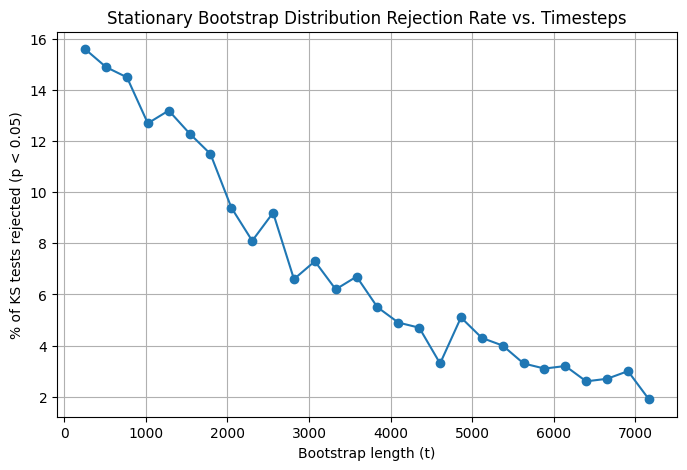

In [9]:
steps = np.arange(256, len(underlying), step=256)
sims = [stationary_bootstrap(underlying, n_sims=1000, t=s, seed=seed) for s in steps]
alpha = 0.05
rejected_counts = []

for i in sims:
    count_reject = 0
    for j in range(len(i)):
        _, pval = stats.ks_2samp(underlying, i[j])
        if pval < alpha:
            count_reject += 1
    rejected_counts.append(count_reject / len(i))

plt.figure(figsize=(8,5))
plt.plot(steps, np.array(rejected_counts)*100, marker='o')
plt.xlabel("Bootstrap length (t)")
plt.ylabel("% of KS tests rejected (p < 0.05)")
plt.title("Stationary Bootstrap Distribution Rejection Rate vs. Timesteps")
plt.grid(True)
plt.show()

## Volatility Clustering

To determine an appropriate block length for the bootstrap, the autocorrelation structure of squared returns was analyzed across several average block sizes $L$ up to the max lag of $50$ where $L=[50, 100, 200, 400]$.

Autocorrelation measures the linear relationship between lagged values of a time series. For example, $r_1$ measures $y_t$ and $y_{y-1}$.
$$
r_k = \frac{\sum^T_{t=k+1}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum^T_{t=1}(y_t - y)^2}
$$
where $T$ is the length of the time series, $\bar{y}$ is the mean of the series, $k$ is the lag (or time delay).

From all simulated ACFs, we constructed pointwise $(1-\alpha)100\%$ confidence interval bands and the bootstrap mean ACF. Then, through visual diagnostics, we will select the best average block size to preserve the volatility clustering property of the underlying. If the underlying curve shows positive, slowly decaying correlation at short lags and largely falls within the confidence interval, it is indicative that the bootstrap simulations preserve the clustering strength seen in the data.

Source: https://otexts.com/fpp2/autocorrelation.html

In [10]:
class VolCluster:
    def __init__(self, underlying_df:pd.Series, sims:np.ndarray, max_lag:int, alpha:float=0.05):
        self.underlying = underlying_df.copy()
        self.sims = sims.copy()
        self.max_lag = int(max_lag)
        self.alpha = alpha
    
    def _acf_results(self) -> tuple[np.ndarray, np.ndarray]:
        acf_sq_u = acf(self.underlying**2, nlags=self.max_lag)
        acf_sq_b  = np.array([acf(self.sims[i]**2, nlags=self.max_lag) for i in range(len(self.sims))])
        return (acf_sq_u, acf_sq_b)
    
    def _get_bounds(self) -> tuple[float, float]:
        interval = self.alpha*100/2
        lb, ub = interval, 100-interval
        return (lb, ub)
    
    def _bs_stats(self, acf_sq_b:np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        lb, ub = self._get_bounds()
        acf_sq_b_mean = acf_sq_b.mean(axis=0)
        acf_sq_b_lo = np.percentile(acf_sq_b, lb, axis=0)
        acf_sq_b_hi = np.percentile(acf_sq_b, ub, axis=0)
        return (acf_sq_b_mean, acf_sq_b_lo, acf_sq_b_hi)
    
    def plot_acf_band(self, avg_block_size:float=None) -> plt.Figure:
        acf_sq_u, acf_sq_b = self._acf_results()
        acf_sq_b_mean, acf_sq_b_lo, acf_sq_b_hi = self._bs_stats(acf_sq_b)
        lags = np.arange(self.max_lag+1)
        
        base_title = "Volatility Clustering: ACF($r_t^2$)"
        title = base_title if avg_block_size is None else base_title+f' with L={avg_block_size}'
        
        plt.figure(figsize=(8,5))
        plt.fill_between(
            lags, acf_sq_b_lo, acf_sq_b_hi,
            color='lightblue', alpha=0.4, label=f'Bootstrap {100-self.alpha*100}% CI'
        )
        
        plt.plot(lags, acf_sq_b_mean, color='blue', linewidth=2, label='Bootstrap Mean ACF')
        plt.plot(lags, acf_sq_u, color='black', linestyle='--', linewidth=2, label='Underlying ACF')
        plt.axhline(0, color='gray', linewidth=1)
        
        plt.xlabel("Lag")
        plt.ylabel("ACF of squared returns")
        plt.title(str(title))
        plt.legend()
        
        plt.grid(alpha=0.3)
        plt.tight_layout()
        return plt.gcf()

Based on the results, the average block size of: 
- $L=50$ underestimate the persistence in volatility, causing the bootstrap ACF to decay faster than the underlying data.
- $L=[100, 200]$ enabled the bootstrap to closely track the underlying, and effectively preserves the clustering of volatility while maintaining adequate resampling variability, with the better fit being $L=200$.
- $L=400$ produce minimal improvement and could lead to over tuning. 

Therefore, we shall go with the block size of $L=200$.

In [11]:
steps = len(underlying)
max_lag = 50
alpha = 0.05

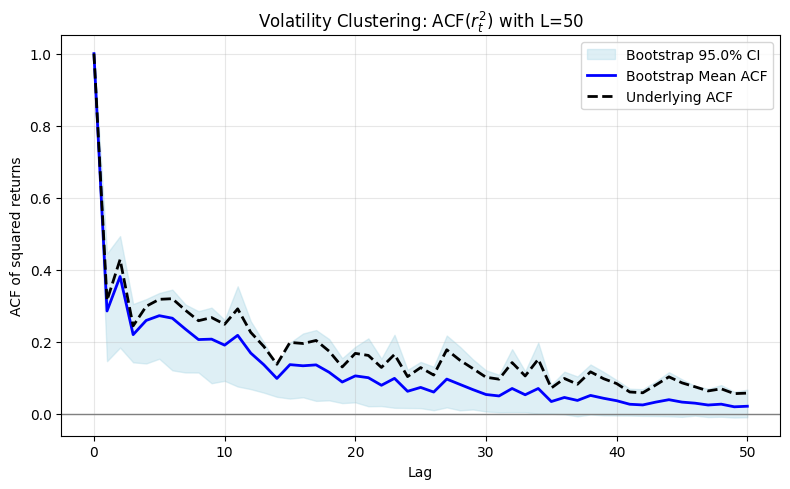

In [12]:
avg_block_size=50
sims = stationary_bootstrap(underlying, n_sims=1000, t=steps, avg_block_size=avg_block_size, seed=seed)
vc = VolCluster(underlying, sims, max_lag, alpha)
fig1 = vc.plot_acf_band(avg_block_size=avg_block_size)

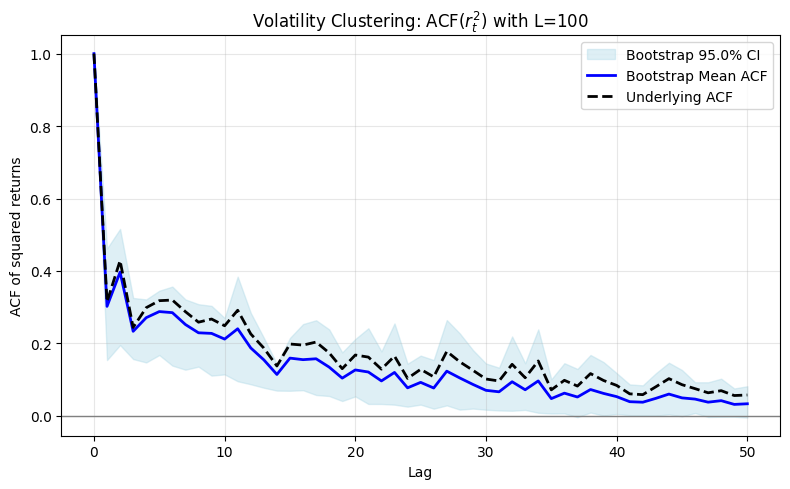

In [13]:
avg_block_size=100
sims = stationary_bootstrap(underlying, n_sims=1000, t=steps, avg_block_size=avg_block_size, seed=seed)
vc = VolCluster(underlying, sims, max_lag, alpha)
fig1 = vc.plot_acf_band(avg_block_size=avg_block_size)

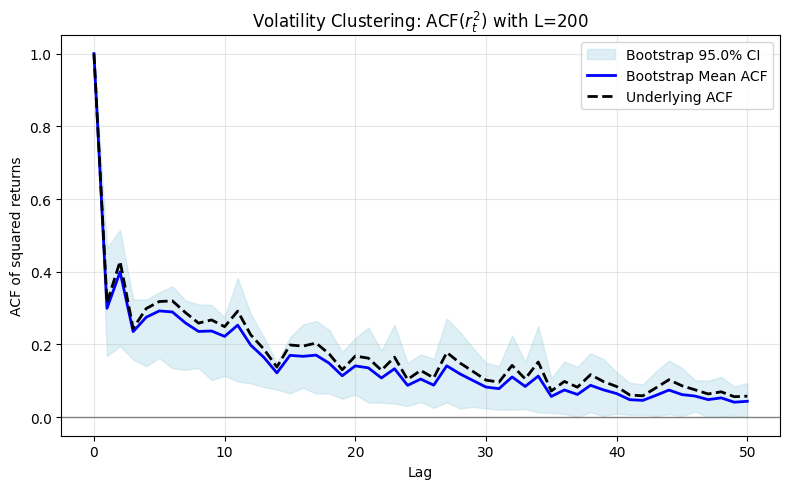

In [14]:
avg_block_size=200
sims = stationary_bootstrap(underlying, n_sims=1000, t=steps, avg_block_size=avg_block_size, seed=seed)
vc = VolCluster(underlying, sims, max_lag, alpha)
fig1 = vc.plot_acf_band(avg_block_size=avg_block_size)

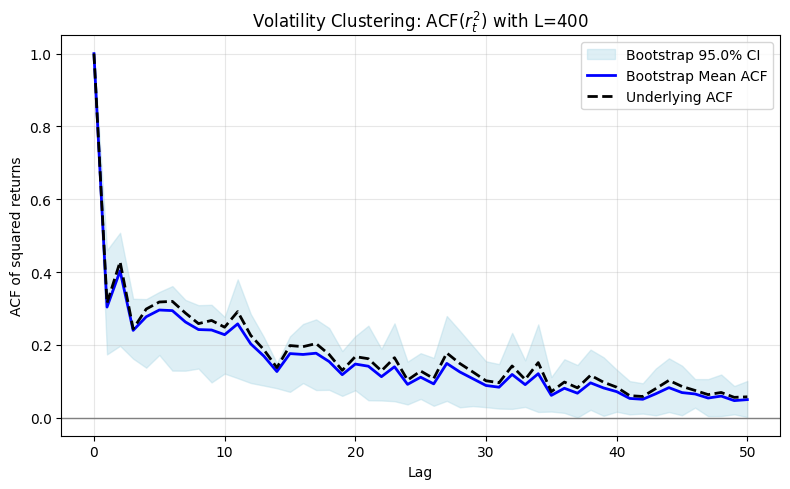

In [15]:
avg_block_size=400
sims = stationary_bootstrap(underlying, n_sims=1000, t=steps, avg_block_size=avg_block_size, seed=seed)
vc = VolCluster(underlying, sims, max_lag, alpha)
fig1 = vc.plot_acf_band(avg_block_size=avg_block_size)

# Environment

In our environment, we will be working in Discrete space where weights go from -1 to 1 in steps of 0.25. We will also only be using SPY returns and replacing the GenLSTM with our bootstrap method. The aim is to simplify the paper, while ensuring an apple to apple comparison.

In [6]:
# Initialize Environment
env = PortfolioEnv(spy_df['log_return'], avg_block_size=200, seed=123)
state, info = env.reset()
print("Initial State Shape:", state.shape)
print("First 5 state values:", state[0, :5].cpu().numpy())

Initial State Shape: torch.Size([8, 63])
First 5 state values: [ 0.00715705 -0.00465514  0.00358305  0.00671171  0.0115022 ]


In [8]:
# Run Random Policy
done = torch.zeros((env.batch_size, 1), dtype=torch.bool)
total_rewards = torch.zeros(env.batch_size)
step_count = 0
while not done.all():
    actions = torch.randint(0, env.action_space.n, (env.batch_size, 1))
    next_state, reward, done, _, info = env.step(actions)
    
    total_rewards += reward.squeeze()
    step_count += 1
    print(f"Step {step_count}: Avg Reward {reward.mean().item():.6f}")

    if step_count == 5:
        break

Step 1: Avg Reward -0.000617
Step 2: Avg Reward 0.002287
Step 3: Avg Reward -0.000514
Step 4: Avg Reward -0.004788
Step 5: Avg Reward 0.002029
